In [1]:
import wandb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List

api = wandb.Api()
sns.set_style("whitegrid")
sns.set_context(
    "talk",
    font_scale=1.5
)
sns.set_palette(
    palette=sns.color_palette()
)

save_path = Path("/Users/alexanderlontke/Desktop")

In [2]:
def get_run_history(api: wandb.Api, project_name:str, run_name: str,):
    runs = api.runs(project_name)
    for run in runs:
        if run.name == run_name:
            return run.history()
    return None

def get_run_summary(api: wandb.Api, project_name:str, run_name: str,):
    runs = api.runs(project_name)
    for run in runs:
        if run.name == run_name:
            return run.summary
    return None

def match_name(name:str):
    nl = name.lower()
    if "simclr" in nl:
        return "SimCLR"
    elif "vae" in nl:
        return "VAE"
    elif "bigan" in nl:
        return "BiGAN"
    elif "random" in nl:
        return "Random Init"
    else:
        return None

def visualize_training_trajectory(
        run_history: pd.DataFrame,
        x_key:str ="trainer/global_step",
        y_key:str ="train/NTXentLoss_step",
        y_label:str = "Train NT-Xent Loss",
        x_label: str="Step",
):
    ax = sns.lineplot(
        data=run_history,
        y=y_key,
        x=x_key,

    )
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

## SimClr Training Trajectory ##

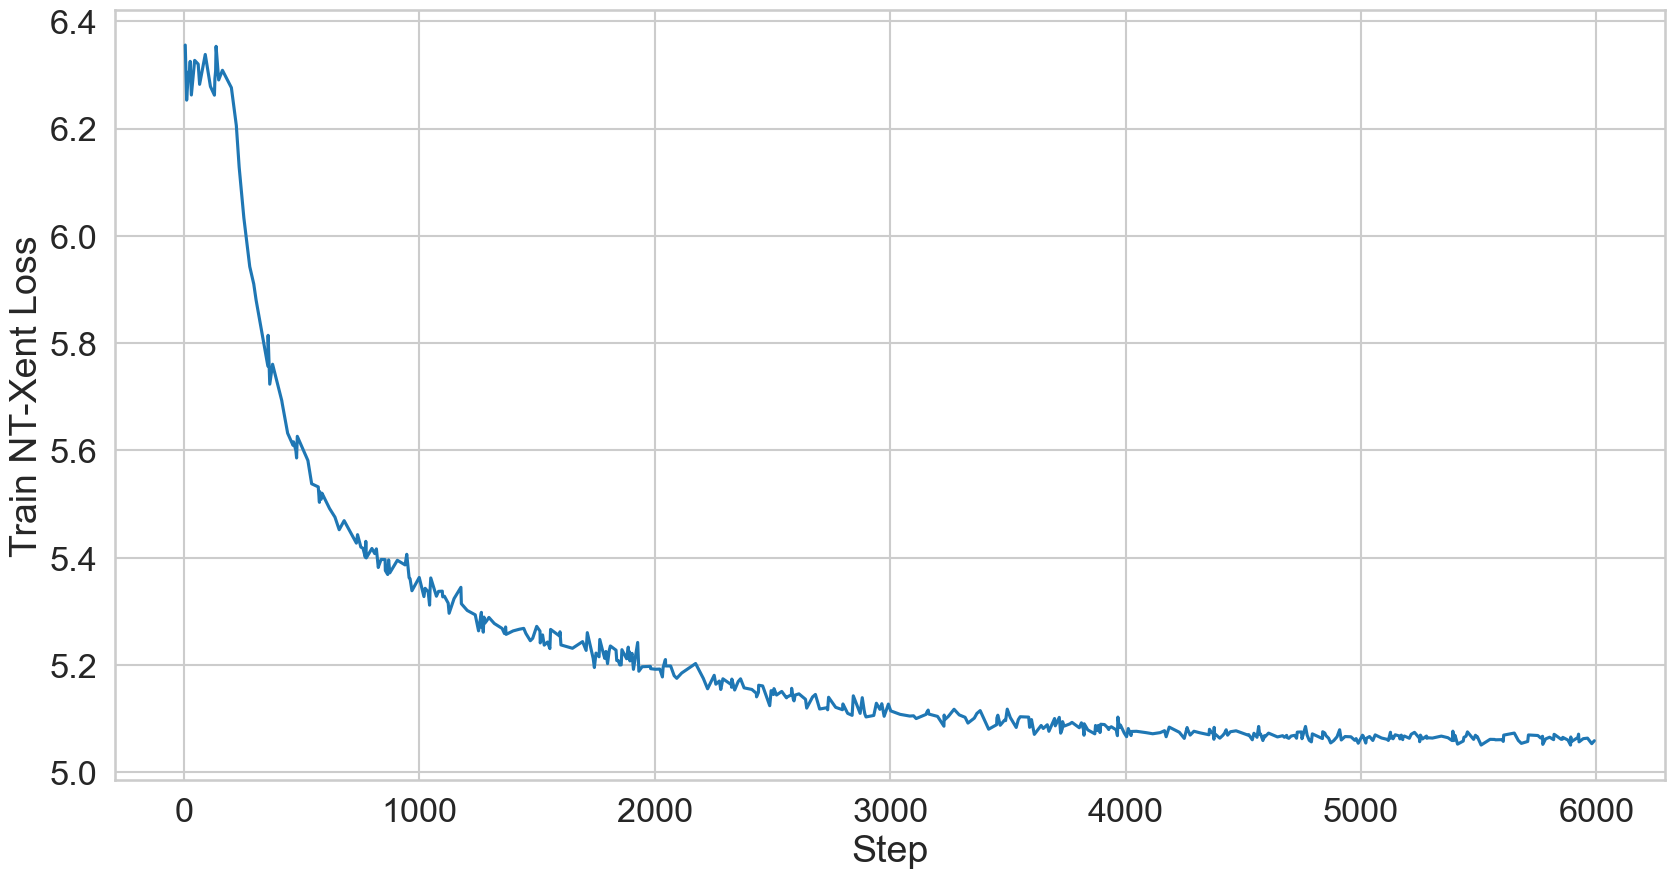

In [3]:
plt.figure(figsize=(20,10))
simclr_run_history = get_run_history(
    api=api,
    project_name= "alontke/ssl-remote-sensing-simclr",
    run_name="splendid-night-40"
)
visualize_training_trajectory(
    run_history=simclr_run_history,
)
plt.savefig(save_path / "simclr_training.png", bbox_inches="tight")

## Classification Downstream Task ##

In [4]:
run_names_of_interest = [
    'random_lr_0.001_frozen_True_linear_True',
    'bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_True_linear_True',
    'vae_bigearthnet.ckpt_lr_0.001_frozen_True_linear_True',
    'SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_True_linear_True',
    'random_lr_0.001_frozen_True_linear_False',
    'bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_True_linear_False',
    'vae_bigearthnet.ckpt_lr_0.001_frozen_True_linear_False',
    'SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_True_linear_False',
    'random_lr_0.001_frozen_False_linear_True',
    'bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_False_linear_True',
    'vae_bigearthnet.ckpt_lr_0.001_frozen_False_linear_True',
    'SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_False_linear_True',
    'random_lr_0.001_frozen_False_linear_False',
    'bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_False_linear_False',
    'vae_bigearthnet.ckpt_lr_0.001_frozen_False_linear_False',
    'SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_False_linear_False'
]

## Training Trajectories ##

In [5]:
def plot_classification_training_trajectories(run_names_of_interest, run_name_infix: Optional[str]= None, aggregate: str = "_step"):
    run_name_key ="run_name"
    classification_run_histories = []
    for run_name in run_names_of_interest:
        if not run_name_infix or run_name_infix in run_name:
            current_history = get_run_history(
                api=api,
                project_name="alontke/ssl-remote-sensing-classification",
                run_name=run_name
            )
            current_history[run_name_key] = run_name
            classification_run_histories += [current_history]
    all_histories = pd.concat(classification_run_histories)
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))

    pivot_table = all_histories.pivot(
        index=aggregate,
        columns=run_name_key,
        values="step/training_loss"
    )
    for column in pivot_table.columns:
        sns.lineplot(
            data=pivot_table[column],
            ax=ax,
            label=match_name(column),
        )
    if aggregate == "_step":
        ax.set_xlabel("Step")
    elif aggregate == "_timestamp":
        ax.set_xlabel("Timestamp")
    ax.set_ylabel("Cross Entropy Loss")
    ax.set_title(f"Training Trajectories (Infix: {infix})")

## Classification Accuracies ##

In [6]:
def plot_classification_accuracy(run_names_of_interest, run_name_infix: Optional[str]= None):
    plt.figure(figsize=(20, 15))
    run_name_to_viz = "Run Name"
    metric_to_viz = "Accuracy"
    metrics = {
        metric_to_viz: [],
        run_name_to_viz: [],
    }
    for run_name in run_names_of_interest:
        if not run_name_infix or run_name_infix in run_name:
            current_metric = get_run_summary(
                api=api,
                project_name="alontke/ssl-remote-sensing-classification",
                run_name=run_name
            )["classification_report"]["accuracy"]
            metrics[run_name_to_viz] += [match_name(run_name)]
            metrics[metric_to_viz] += [current_metric]
    ax = sns.barplot(
        data=metrics,
        x=run_name_to_viz,
        y=metric_to_viz
    )
    ax.set_title(f"Accuracy (Infix: {infix})")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Pre-Text Task")

## Frozen: True, Linear: True ##

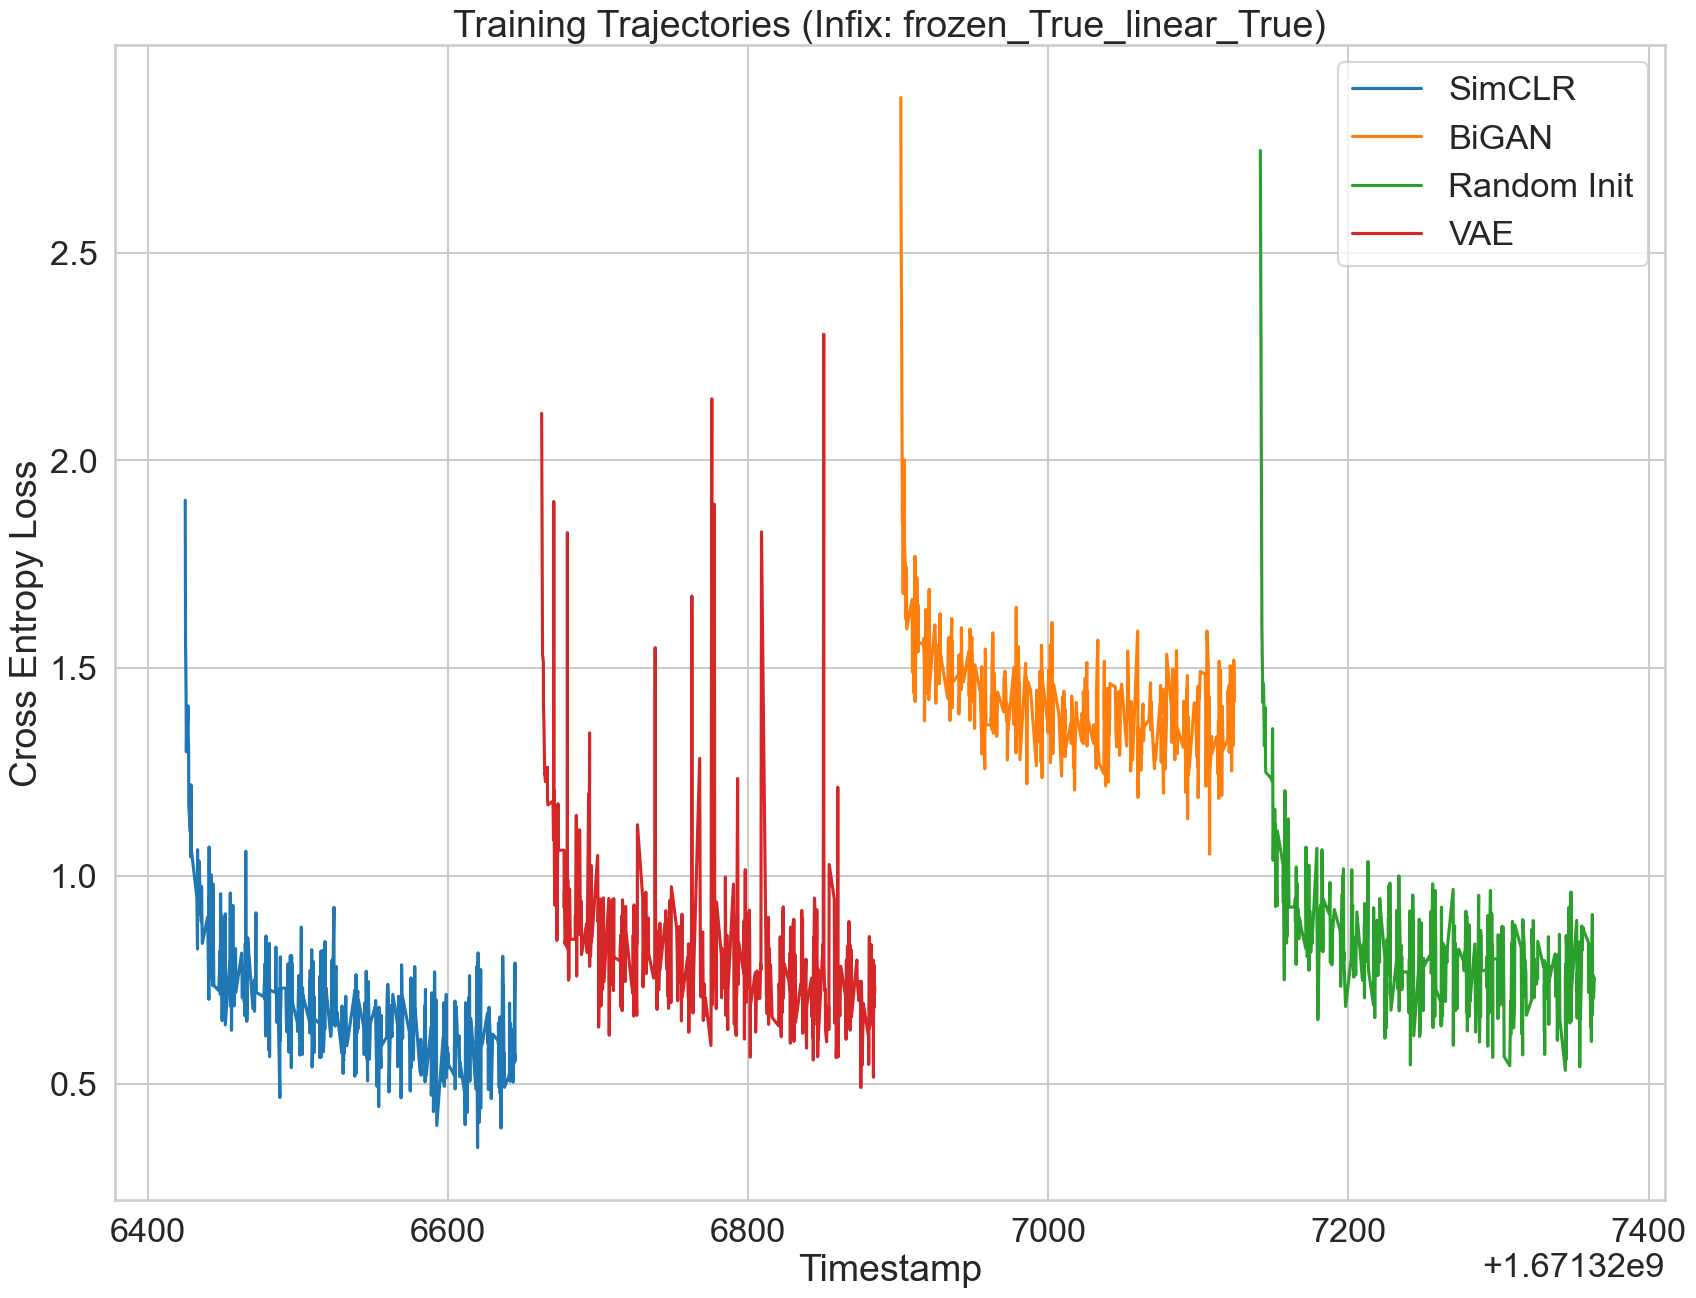

In [7]:
infix = "frozen_True_linear_True"
plot_classification_training_trajectories(run_names_of_interest, run_name_infix=infix, aggregate="_timestamp")
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

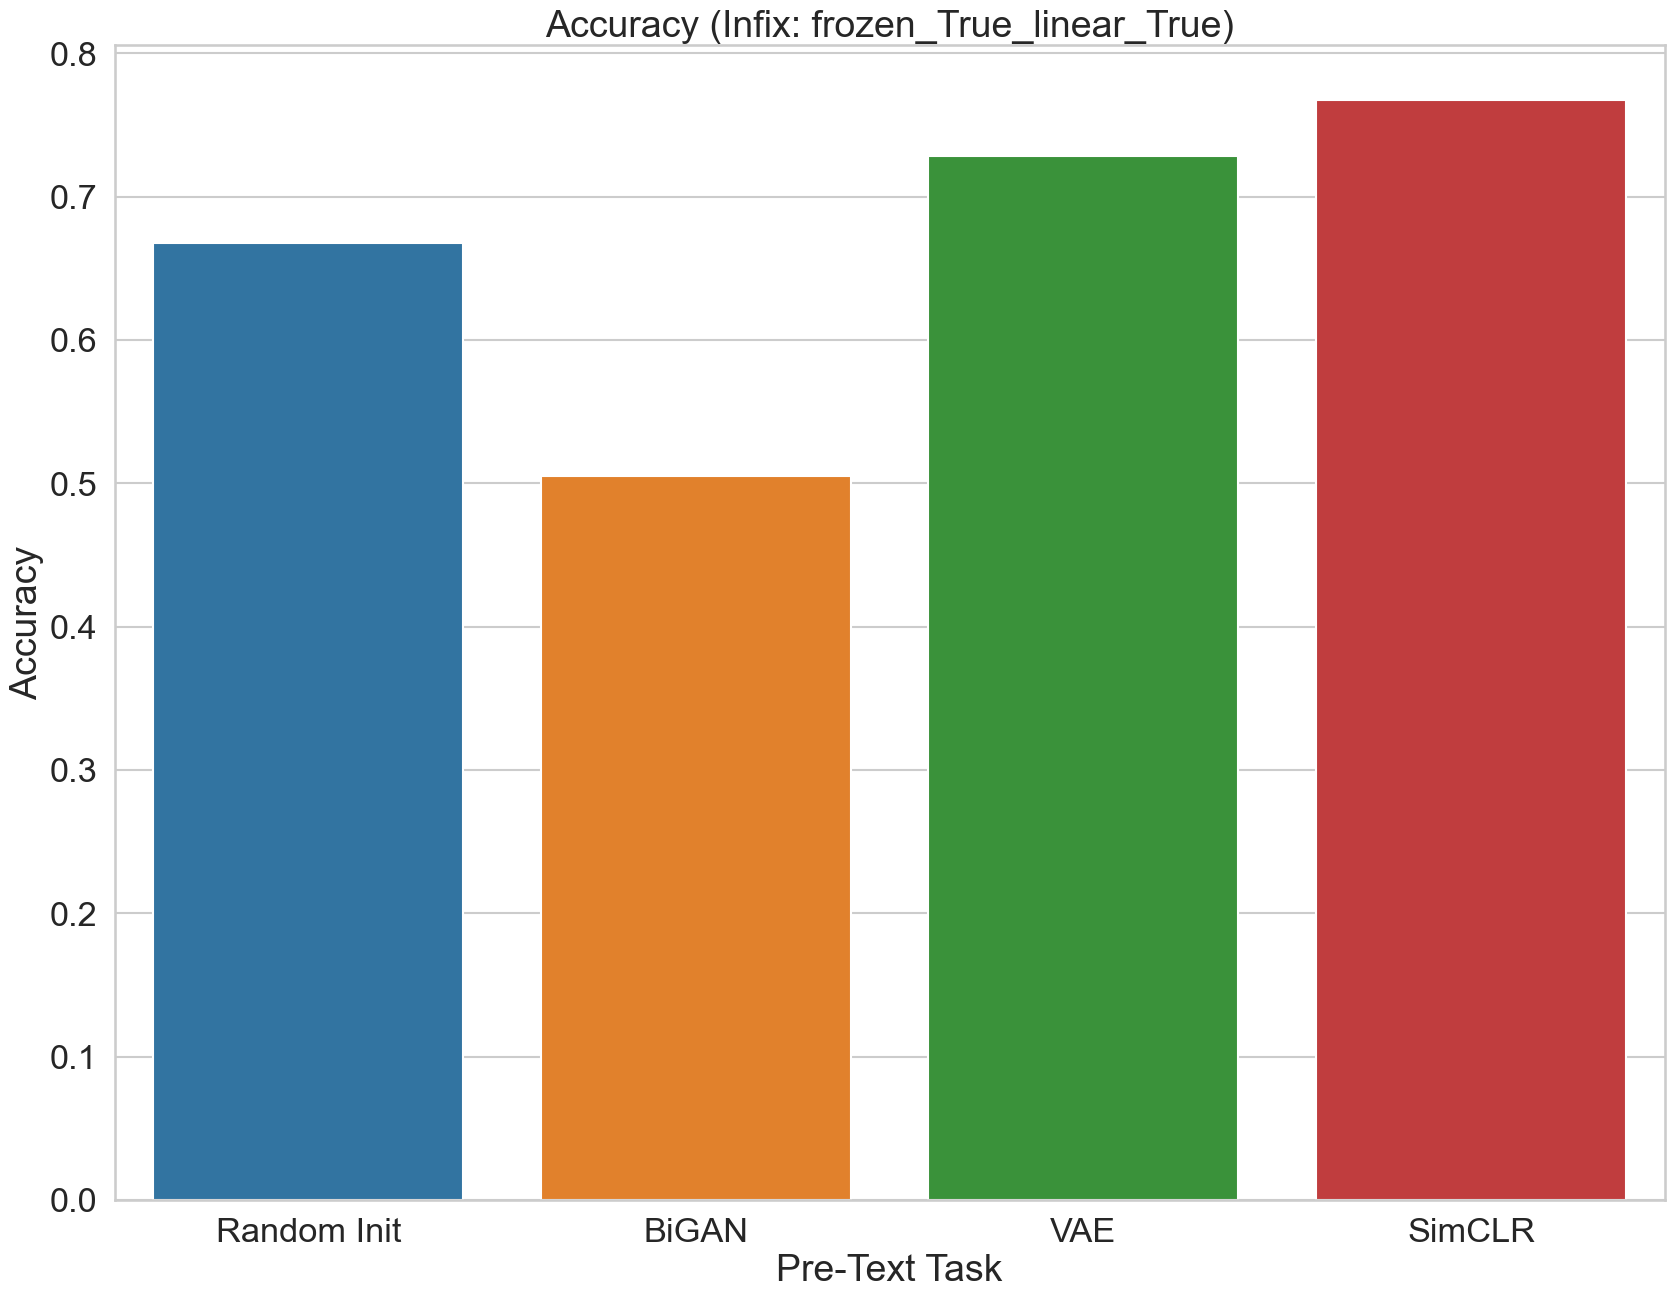

In [8]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

## Frozen: False, Linear: True ##

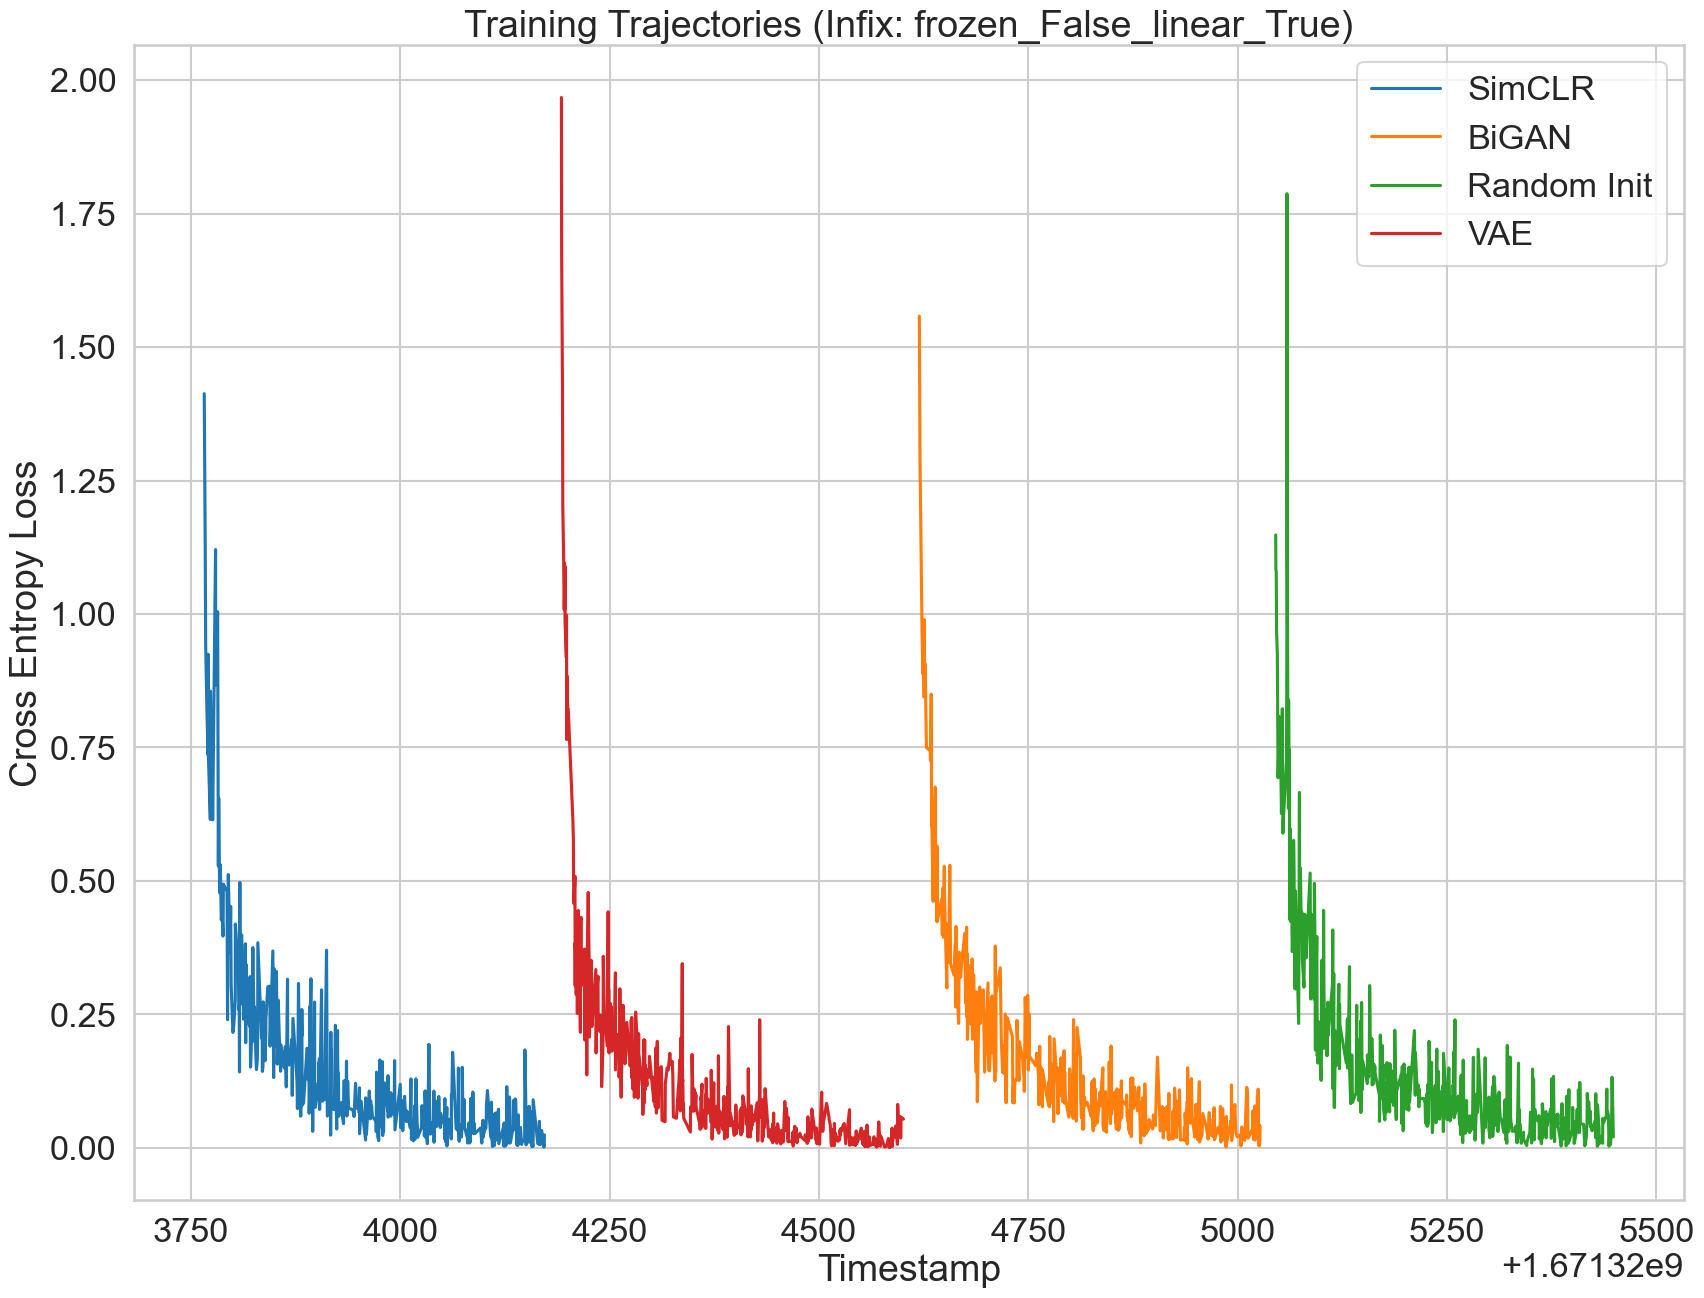

In [9]:
infix = "frozen_False_linear_True"
plot_classification_training_trajectories(run_names_of_interest, run_name_infix=infix, aggregate="_timestamp")
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

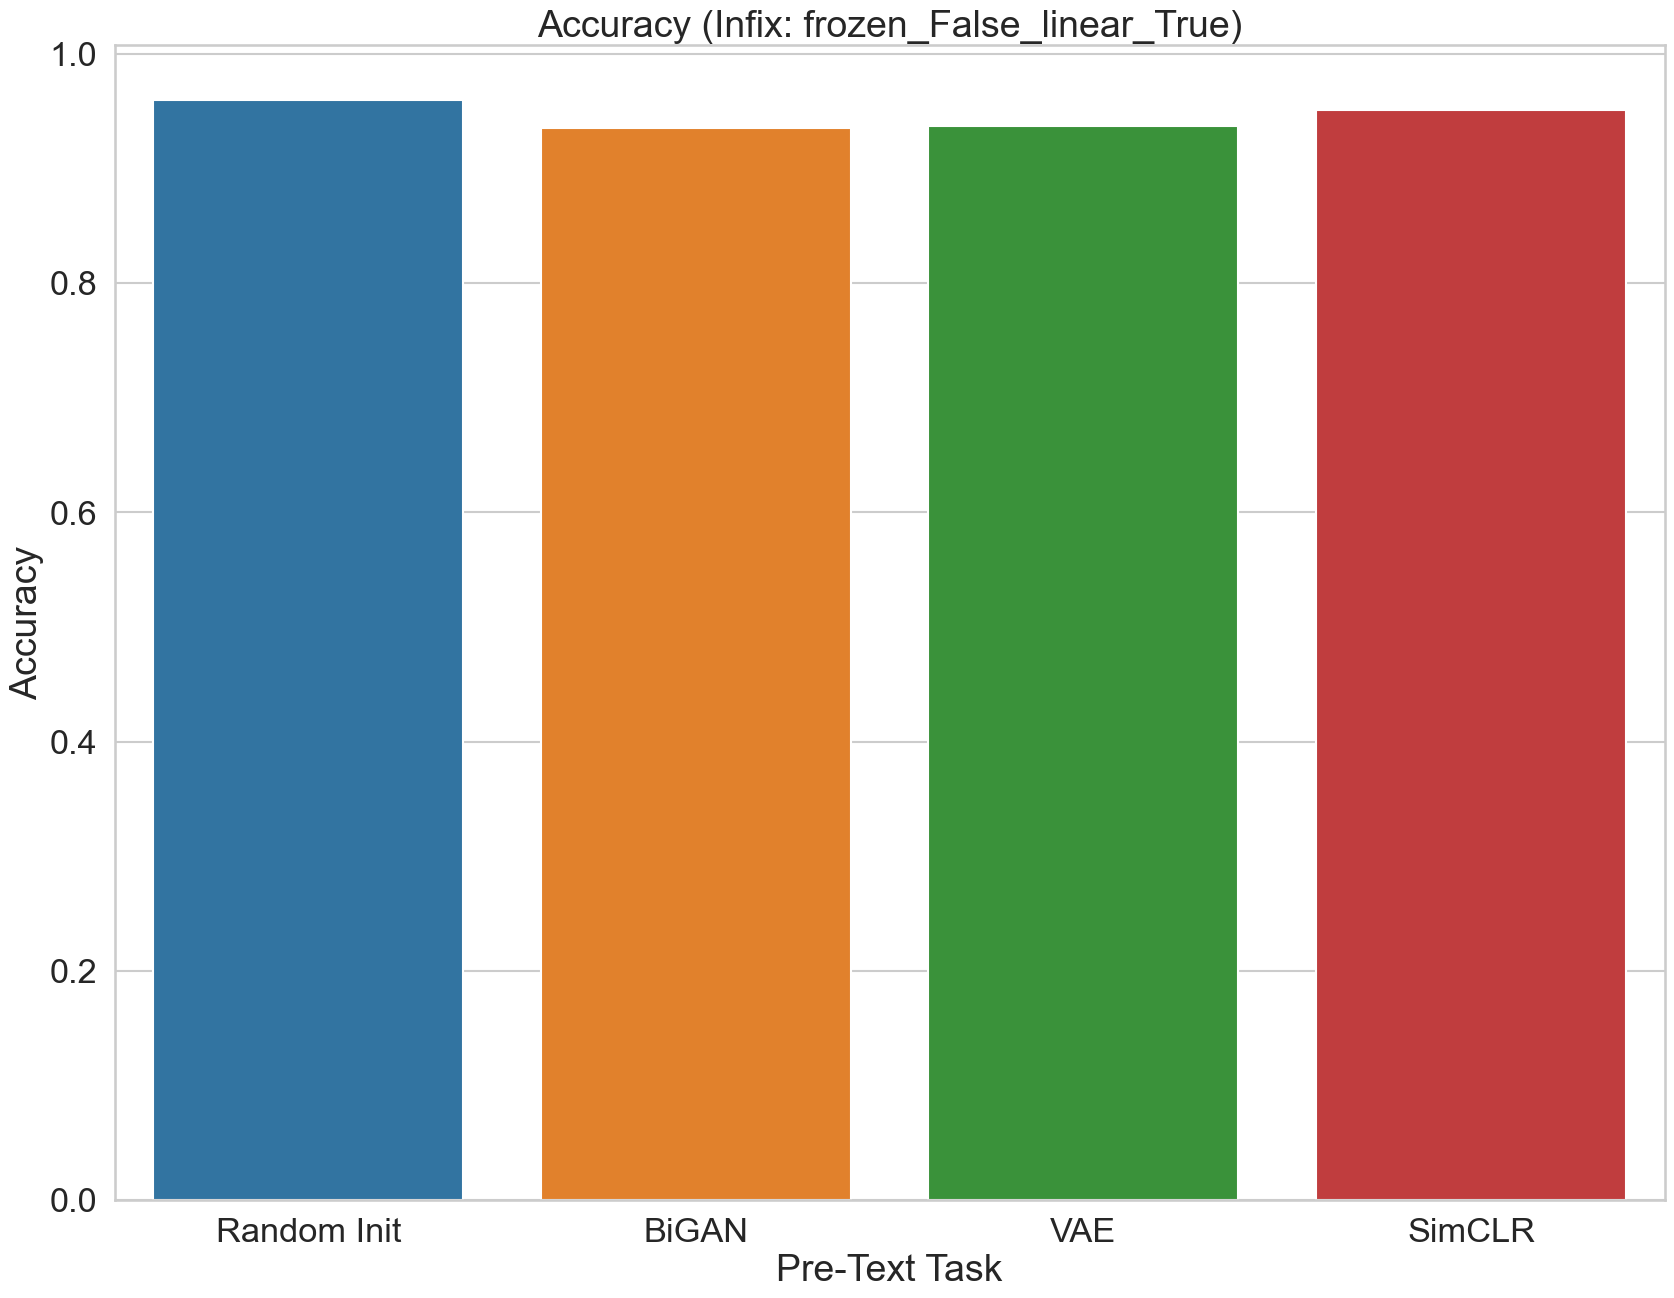

In [10]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

## Frozen: True, Linear: False ##

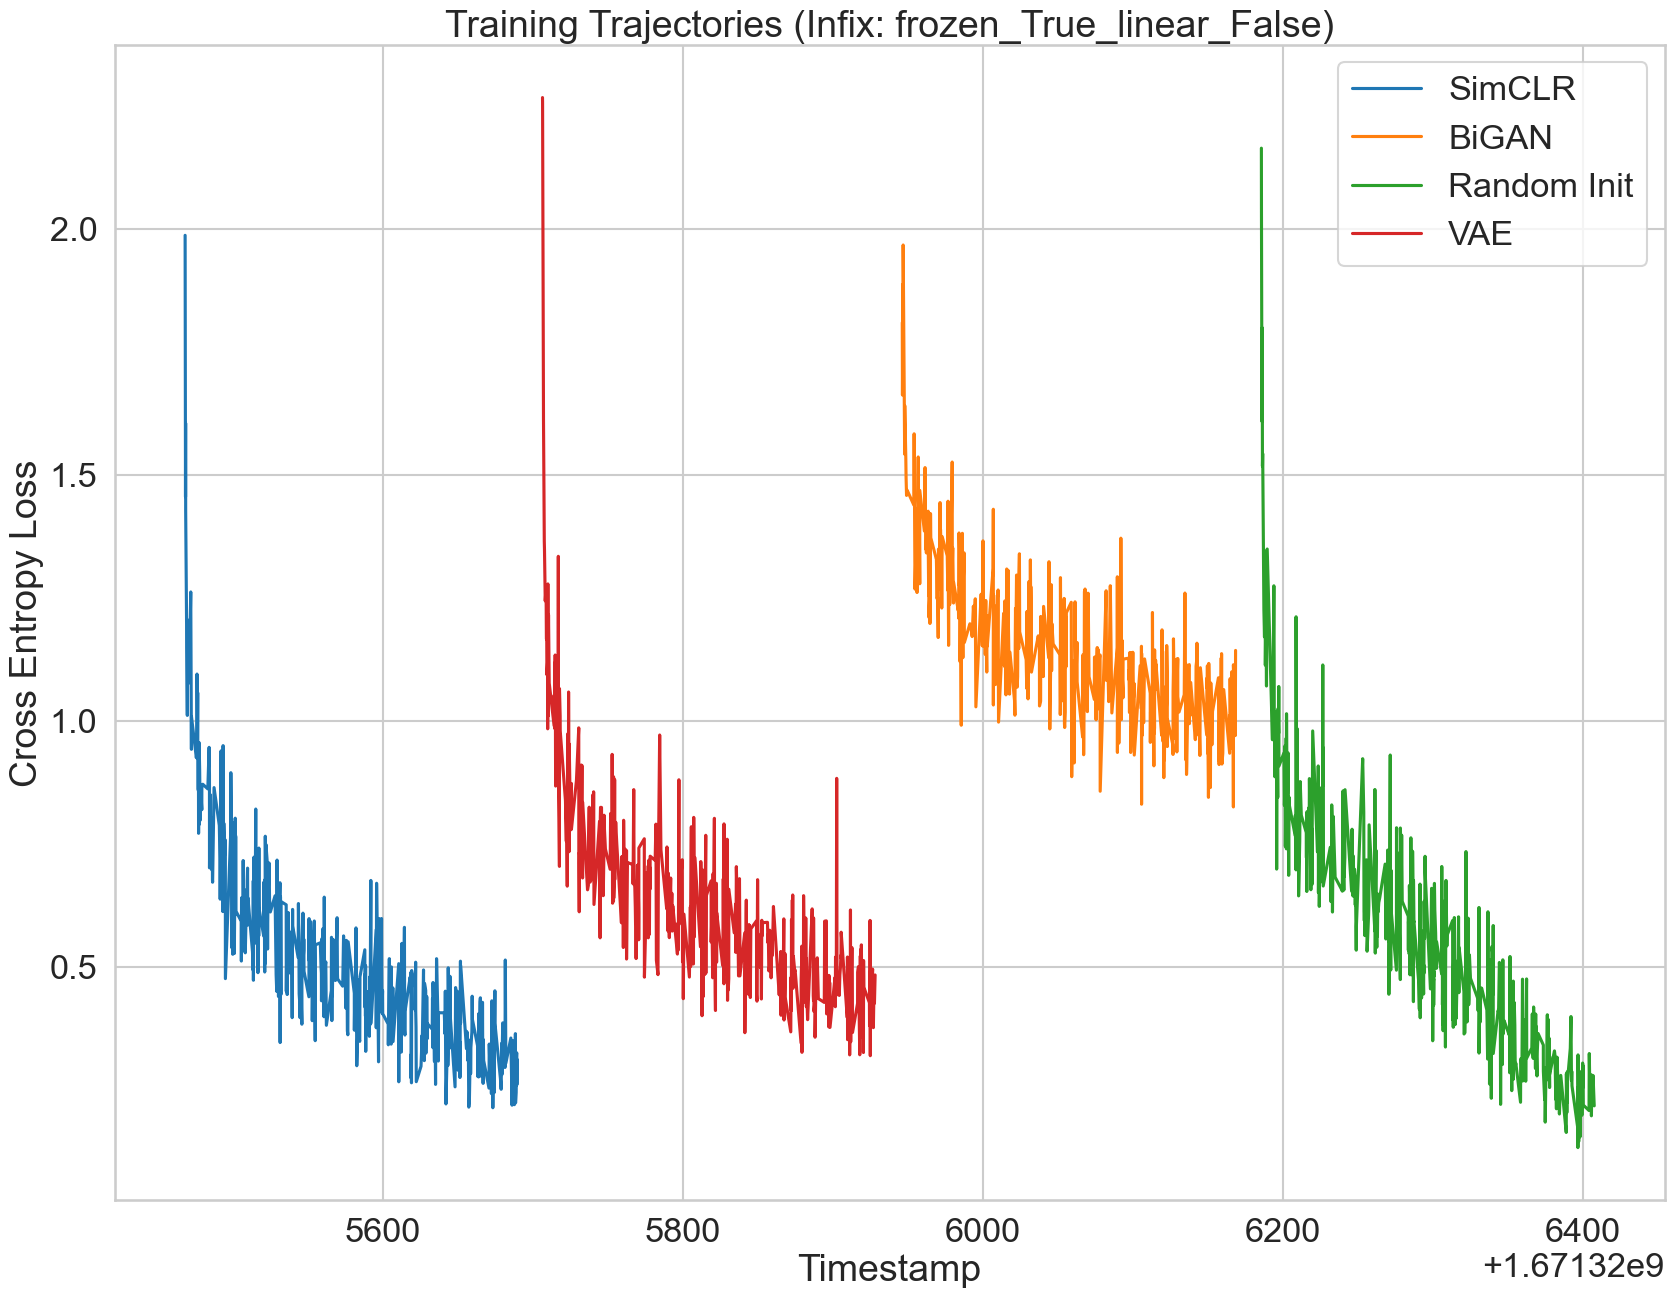

In [11]:
infix = "frozen_True_linear_False"
plot_classification_training_trajectories(run_names_of_interest, run_name_infix=infix, aggregate="_timestamp")
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

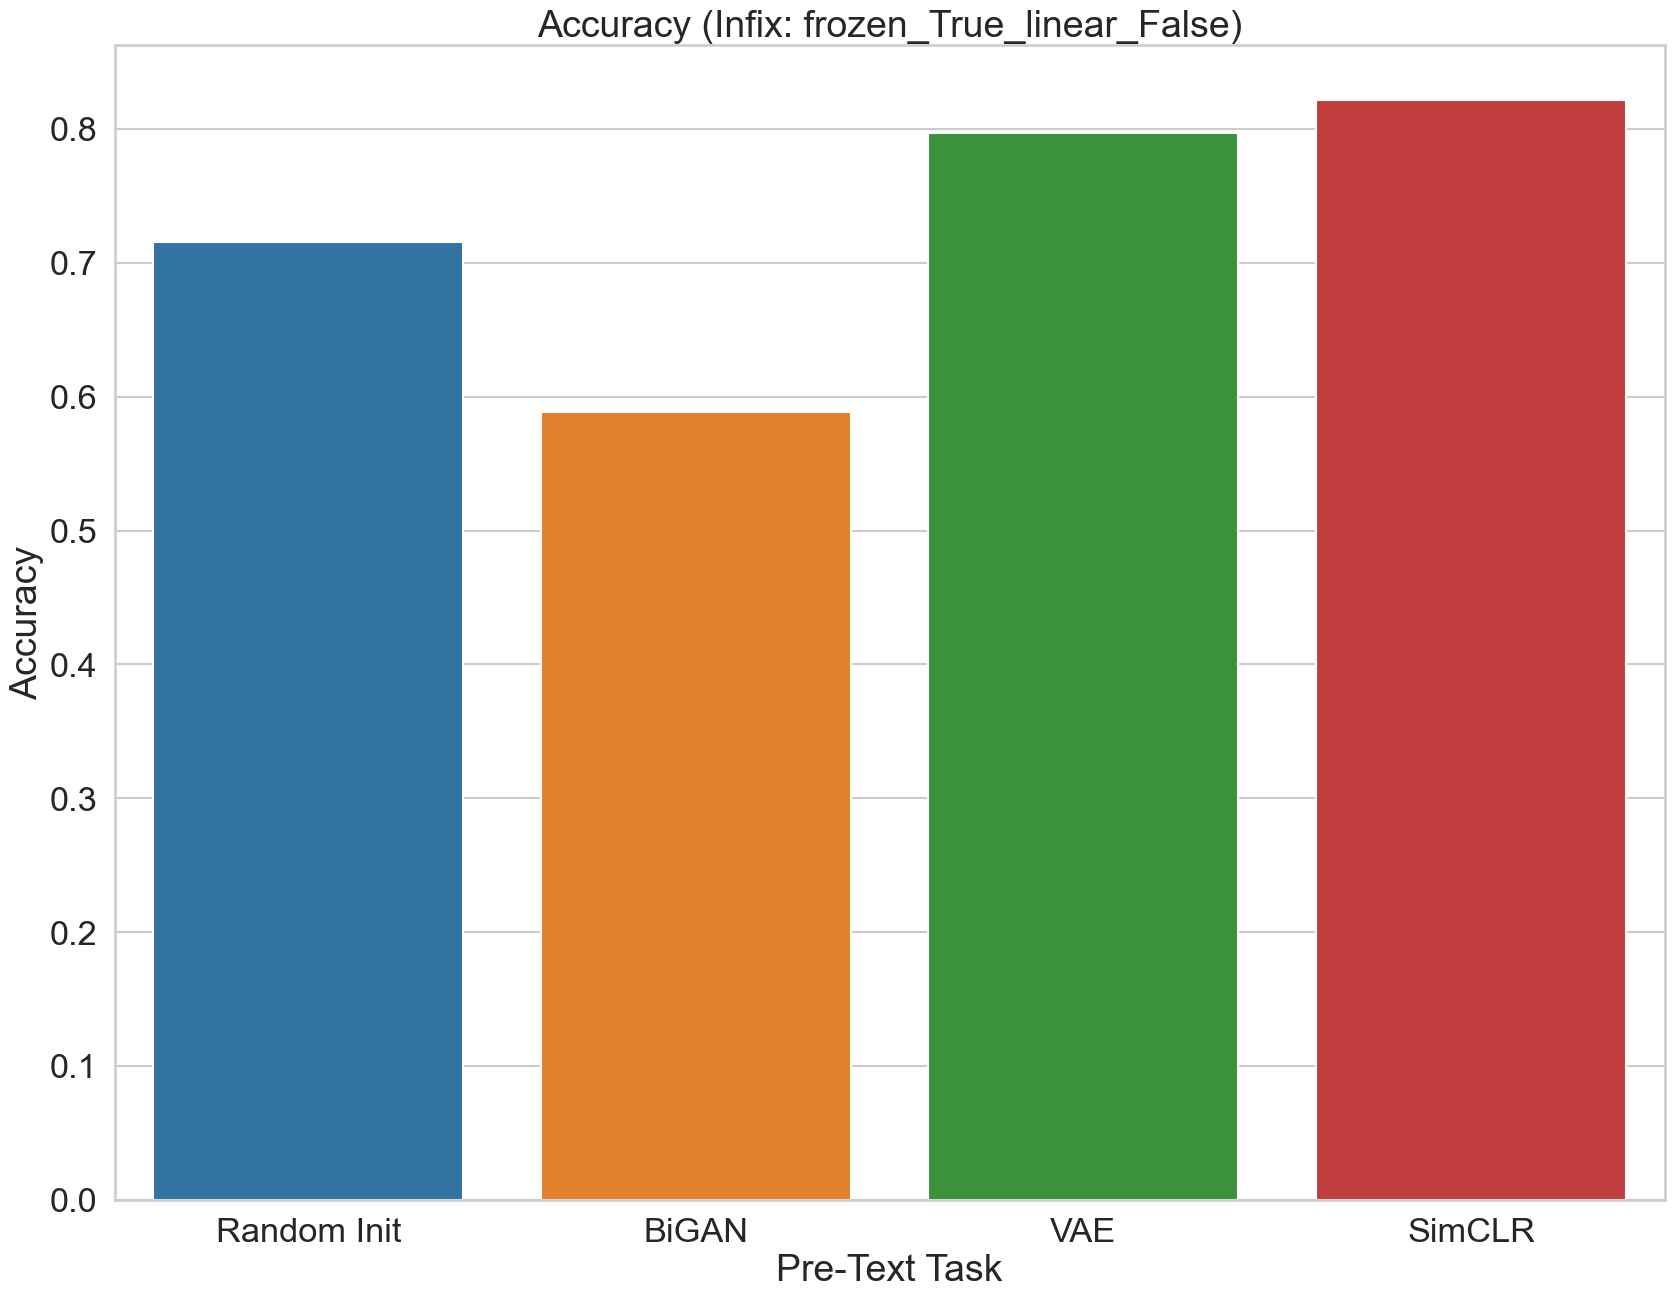

In [12]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

## Frozen: False, Linear: False ##

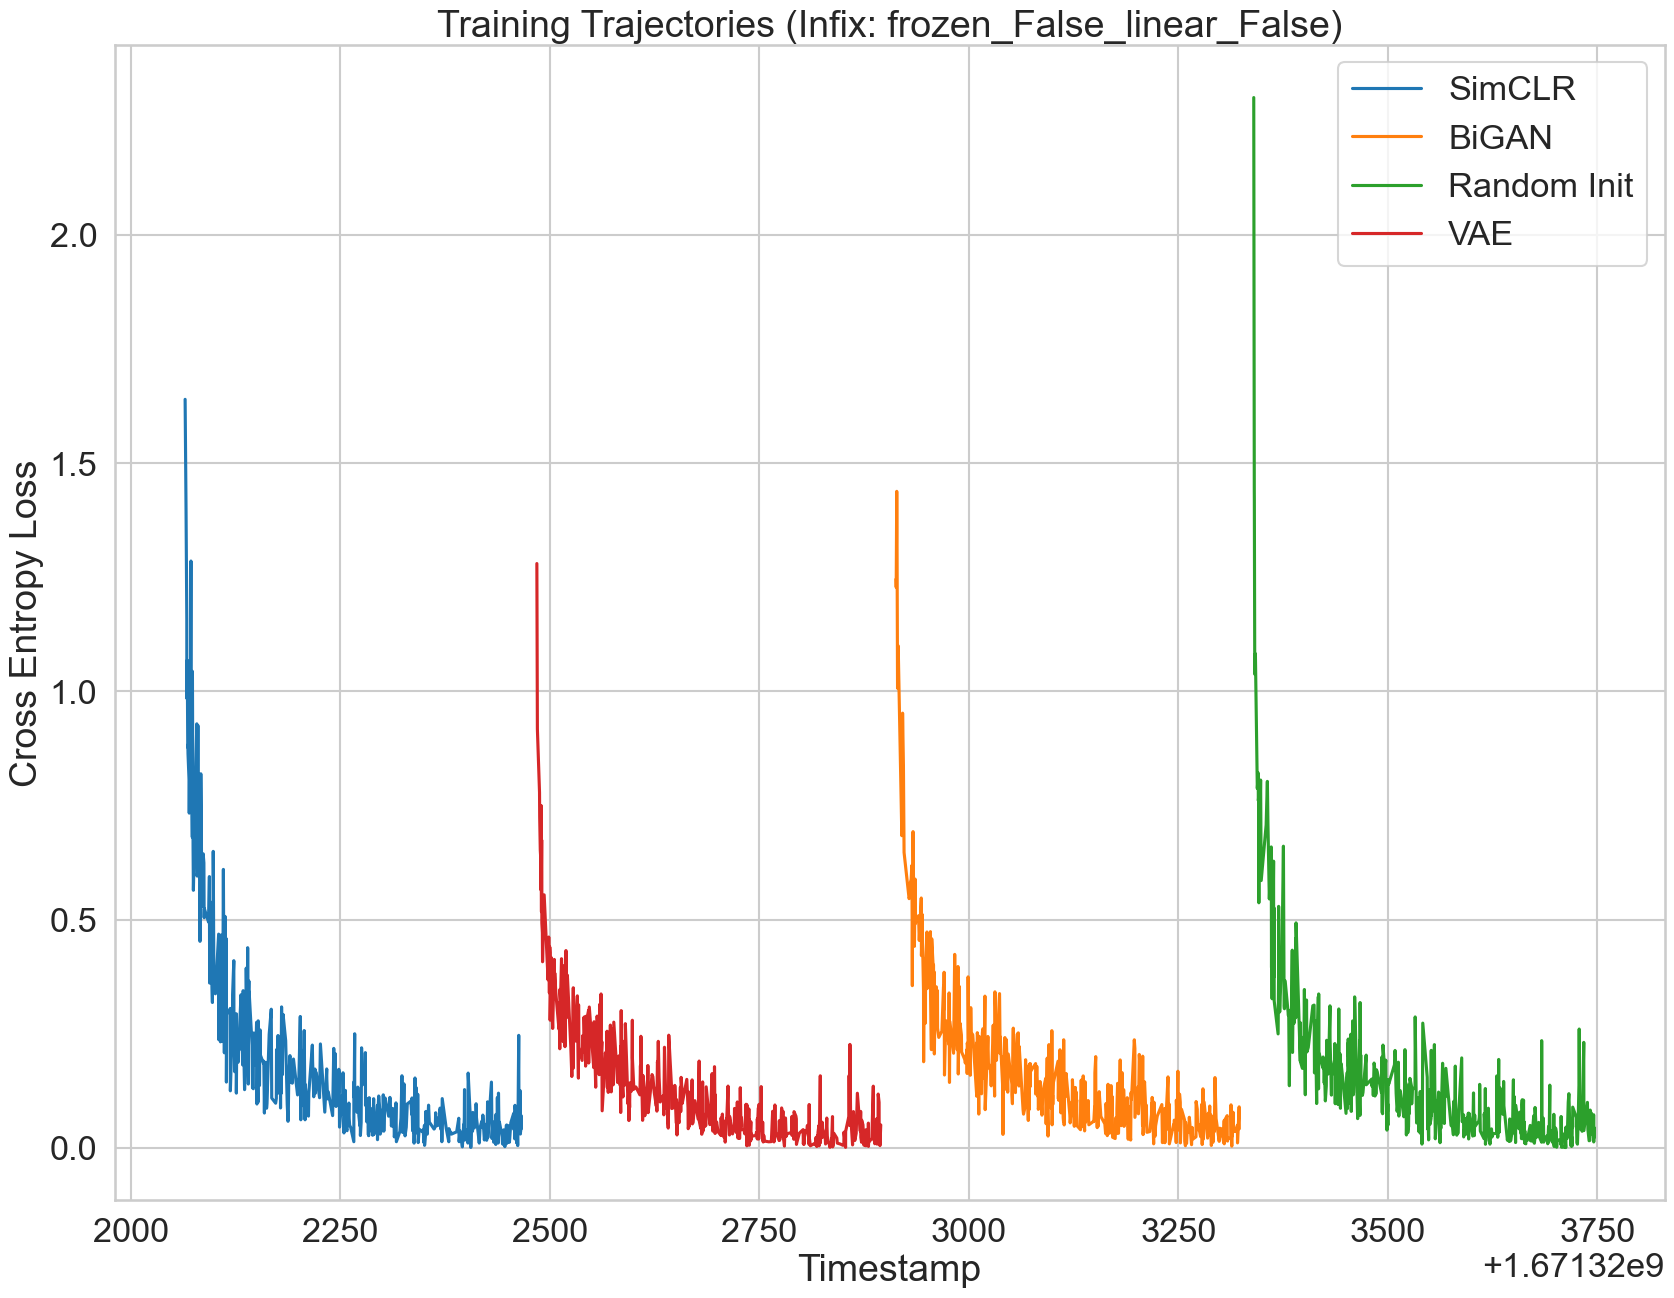

In [13]:
infix = "frozen_False_linear_False"
plot_classification_training_trajectories(run_names_of_interest, run_name_infix=infix, aggregate="_timestamp")
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

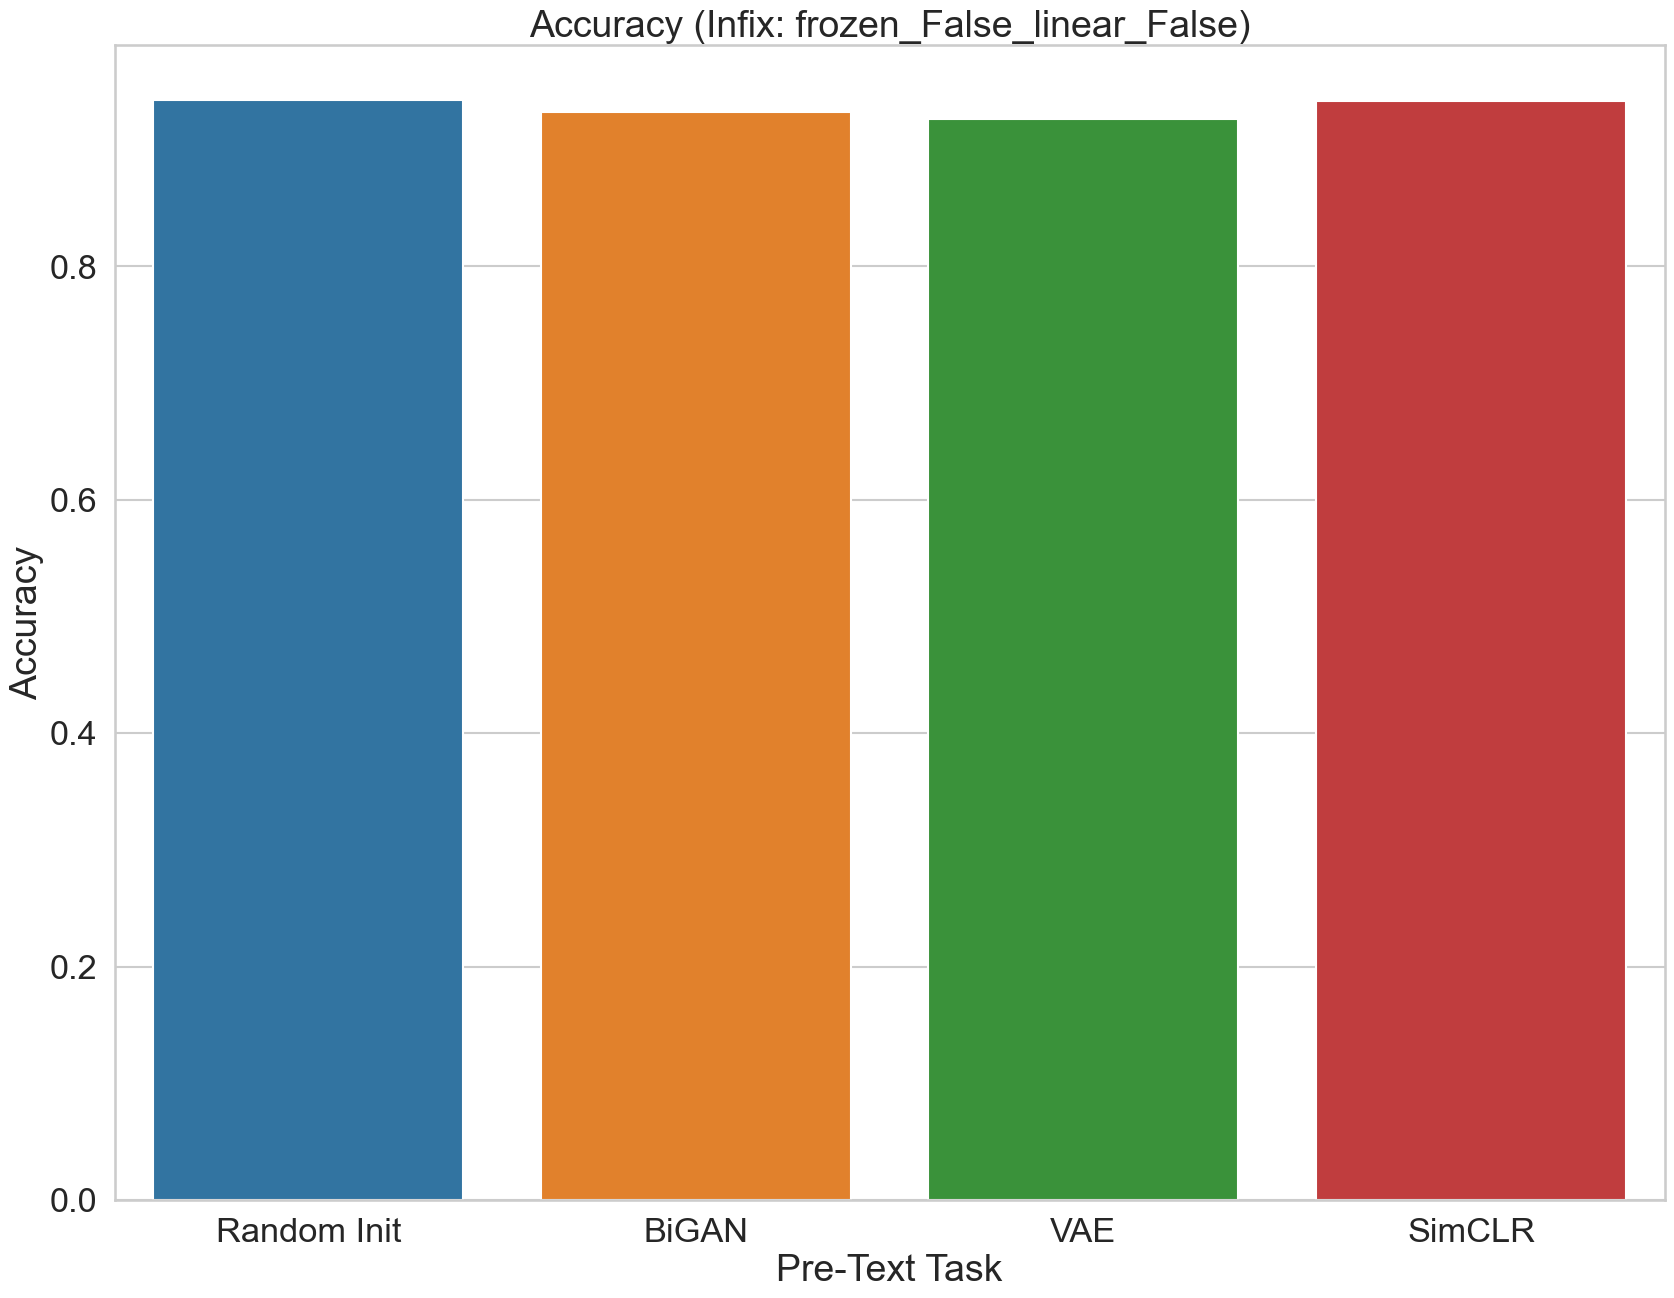

In [14]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")